# Capstone Project - The Battle of Neighborhoods
---

## Table of Contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Analysis](#analysis)

# Introduction: Business Problem <a name="introduction"></a>
---

In this project we will try to find an optimal location for a restaurant in Seattle, Washington. Specifically, it will be targeted on those interested in opening an Italian restaurant.

We will try to detect locations that are not already crowded with restaurants. We are also particularly interested in areas with no Italian restaurants in vicinity. 

We will use our data science powers to generate a few most promising neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

# Data <a name="data"></a>
---

We are going to be using this data set with Seattle Neighborhoods by Zip Codes from this page 'http://www.agingkingcounty.org/wp-content/uploads/sites/185/2016/09/SubRegZipCityNeighborhood.pdf'. It is a pdf file containing excel spreadsheet "Sub-Regional, City and Neighborhood Designations by Zip Code". 

I used Adobe Acrobat to extract it into an excel file from the pdf. We are going to use only the data for City of Seattle and its Neighborhoods. We will need only the data from the first page in the section sorted by Seattle Neighborhood which contains all neighborhood in the City of Seattle specifically and corresponding zip codes.

Also, we will use Foursquare API to later extract data for venues in the corresponding zip codes. 


### Loading and Extracting Data

In [312]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from bs4 import BeautifulSoup as bs

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt

from sklearn.cluster import DBSCAN 
from sklearn.neighbors import NearestNeighbors
import requests
from bs4 import BeautifulSoup as bs
import html5lib
print('Libraries imported.')

Libraries imported.


In [154]:
df = pd.read_excel('SubRegZipCityNeighborhood.xlsx')
df = df.rename(columns={'Seattle Neighborhood': 'Neighborhood'})
df = df.sort_values(by=['ZIP'])
df = df.reset_index(drop=True)
df

ZIP                    City Name       Sub Region         Neighborhood
0   98004                     Bellevue       East Urban             Bellevue
1   98005                     Bellevue       East Urban             Bellevue
2   98006                     Bellevue       East Urban             Bellevue
3   98007                     Bellevue       East Urban             Bellevue
4   98008                     Bellevue       East Urban             Bellevue
5   98009                     Bellevue       East Urban             Bellevue
6   98011                      Bothell            North              Bothell
7   98015                     Bellevue       East Urban             Bellevue
8   98028                      Kenmore            North              Kenmore
9   98033                     Kirkland       East Urban             Kirkland
10  98034                     Kirkland       East Urban             Kirkland
11  98039                       Medina       East Urban               Medina
12  98040                Mercer Island       East Urban        Mercer Island
13  98041                      Bothell            North              Bothell
14  98052                      Redmond       East Urban              Redmond
15  98053                      Redmond       East Urban              Redmond
16  98055                       Renton      South Urban               Renton
17  98056                       Renton      South Urban               Renton
18  98058                       Renton      South Urban               Renton
19  98059                       Renton       East Urban               Renton
20  98073                      Redmond       East Urban              Redmond
21  98082                      Bothell            North              Bothell
22  98083                     Kirkland       East Urban             Kirkland
23  98101                      Seattle          Seattle             Downtown
24  98102                      Seattle          Seattle         Capitol Hill
25  98103                      Seattle          Seattle           Lake Union
26  98104                      Seattle          Seattle             Downtown
27  98105                      Seattle          Seattle            Northeast
28  98106                      Seattle          Seattle             Delridge
29  98107                      Seattle          Seattle              Ballard
30  98108                      Seattle          Seattle             Duwamish
31  98109                      Seattle          Seattle  Queen Anne/Magnolia
32  98111                      Seattle          Seattle             Downtown
33  98112                      Seattle          Seattle         Capitol Hill
34  98114                      Seattle          Seattle             Downtown
35  98115                      Seattle          Seattle            Northeast
36  98116                      Seattle          Seattle            Southwest
37  98117                      Seattle          Seattle              Ballard
38  98118                      Seattle          Seattle            Southeast
39  98119                      Seattle          Seattle  Queen Anne/Magnolia
40  98121                      Seattle          Seattle             Downtown
41  98122                      Seattle          Seattle              Central
42  98124                      Seattle          Seattle             Duwamish
43  98125                      Seattle          Seattle                North
44  98126                      Seattle          Seattle             Delridge
45  98129                      Seattle          Seattle             Downtown
46  98133          Shoreline & Seattle  North & Seattle            Northwest
47  98134                      Seattle          Seattle             Duwamish
48  98136                      Seattle          Seattle            Southwest
49  98138                      Seattle      South Urban              Tukwila
50  98144                      Seattle          Seattle            Southeast
51

Now we are going to use zip-codes.com and their Free Level API to obtain geospatial data for our zip codes from the dataframe

In [155]:
latitudes = []
longitudes = []
for code in df['ZIP']:
    info = requests.get('https://api.zip-codes.com/ZipCodesAPI.svc/1.0/QuickGetZipCodeDetails/{}?key=<AE7LR79I8JC8CNQRLGZF>'.format(code)).json()
    lati = info['Latitude']
    latitudes.append(lati)
    long = info['Longitude']
    longitudes.append(long)
df['Latitude'] = latitudes
df['Longitude'] = longitudes

In [156]:
df.head()

ZIP City Name  Sub Region Neighborhood   Latitude   Longitude
0  98004  Bellevue  East Urban     Bellevue  47.617746 -122.210797
1  98005  Bellevue  East Urban     Bellevue  47.620068 -122.173086
2  98006  Bellevue  East Urban     Bellevue  47.552758 -122.150589
3  98007  Bellevue  East Urban     Bellevue  47.619741 -122.142986
4  98008  Bellevue  East Urban     Bellevue  47.605630 -122.108288

### Visualizing
We will map the neighborhoods on the map using the acquired geodata

In [157]:
import folium

address = 'Seattle, Washington'

geolocator = Nominatim(user_agent="seattle_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map = folium.Map(location=[latitude, longitude], zoom_start=10)
neighborhoods = df

for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['ZIP'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)  
    
map

### Connect to Foursquare API and extract the data for nearby venues in each neighborhood

In [158]:
CLIENT_ID = '3OWWV1IKR1G4UXICT2E5V4QS224B4HWYE5XJ0QBSESX0SP14' # your Foursquare ID
CLIENT_SECRET = 'WGZ0KKG1IVLJL424MEC3Z3I0AN3X5WY4TDAV5TI53SKT1ORD' # your Foursquare Secret
VERSION = '20180323' # Foursquare API version

In [159]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [160]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [164]:
seattle_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Bellevue
Bellevue
Bellevue
Bellevue
Bellevue
Bellevue
Bothell
Bellevue
Kenmore
Kirkland
Kirkland
Medina
Mercer Island
Bothell
Redmond
Redmond
Renton
Renton
Renton
Renton
Redmond
Bothell
Kirkland
Downtown
Capitol Hill
Lake Union
Downtown
Northeast
Delridge
Ballard
Duwamish
Queen Anne/Magnolia
Downtown
Capitol Hill
Downtown
Northeast
Southwest
Ballard
Southeast
Queen Anne/Magnolia
Downtown
Central
Duwamish
North
Delridge
Downtown
Northwest
Duwamish
Southwest
Tukwila
Southeast
Northeast
Southwest
SeaTac
Downtown
Shoreline
SeaTac
Shoreline
Downtown
Downtown
Seattle
Downtown
Northwest
Downtown
SeaTac
Downtown
Northeast
Queen Anne/Magnolia


In [165]:
seattle_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0     Bellevue              47.617746             -122.210797   
1     Bellevue              47.617746             -122.210797   
2     Bellevue              47.617746             -122.210797   
3     Bellevue              47.617746             -122.210797   
4     Bellevue              47.617746             -122.210797   

              Venue  Venue Latitude  Venue Longitude   Venue Category  
0     Oil & Vinegar       47.616070      -122.204840     Gourmet Shop  
1               QFC       47.618611      -122.205037      Supermarket  
2       Happy Lemon       47.616070      -122.204912  Bubble Tea Shop  
3             InSpa       47.616589      -122.204904              Spa  
4  Marketplace Cafe       47.617075      -122.204513             Café

Now let's just limit ourselves to the Venue category 'Italian Restaurant'

In [166]:
ital = seattle_venues[seattle_venues['Venue Category'] == 'Italian Restaurant']
ital = ital.reset_index(drop=True)
ital.drop_duplicates(inplace=True)
ital

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0              Bellevue              47.610600             -122.199700   
1              Bellevue              47.610600             -122.199700   
2              Bellevue              47.610600             -122.199700   
6               Bothell              47.760200             -122.204400   
7               Redmond              47.680496             -122.120938   
8               Redmond              47.680496             -122.120938   
9              Downtown              47.611012             -122.333523   
10         Capitol Hill              47.635749             -122.324362   
11         Capitol Hill              47.635749             -122.324362   
12             Downtown              47.602134             -122.328431   
13             Downtown              47.602134             -122.328431   
14              Ballard              47.664823             -122.383784   
15              Ballard              47.664823             -122.383784   
16  Queen Anne/Magnolia              47.634444             -122.341900   
17             Downtown              47.613476             -122.347381   
18             Downtown              47.613476             -122.347381   
19             Downtown              47.601500             -122.330400   
20             Downtown              47.601500             -122.330400   
21             Downtown              47.604718             -122.335237   

                         Venue  Venue Latitude  Venue Longitude  \
0    Pogacha Restaurant & Café       47.610660      -122.199308   
1            Carmines Bellevue       47.611205      -122.203936   
2                   Cantinetta       47.610175      -122.204917   
6                        Amaro       47.761626      -122.208009   
7   Tropea Ristorante Italiano       47.680132      -122.123550   
8                 Blu Sardinia       47.681041      -122.125342   
9            Barolo Ristorante       47.614298      -122.337838   
10                    Serafina       47.638110      -122.325994   
11                   Cicchetti       47.638095      -122.326392   
12                      Salumi       47.599052      -122.332822   
13               Che Sara Sara       47.600204      -122.333807   
14                 Stoneburner       47.666143      -122.382827   
15                   San Fermo       47.667287      -122.384520   
16                Pasta Freska       47.632873      -122.340935   
17                    Tavolàta       47.614313      -122.346677   
18             La Vita e Bella       47.615038      -122.347399   
19                      Salumi       47.599052      -122.332822   
20         Il Terrazzo Carmine       47.598828      -122.334695   
21                Al Boccalino       47.601737      -122.335873   

        Venue Category  
0   Italian Restaurant  
1   Italian Restaurant  
2   Italian Restaurant  
6   Italian Restaurant  
7   Italian Restaurant  
8   Italian Restaurant  
9   Italian Restaurant  
10  Italian Restaurant  
11  Italian Restaurant  
12  Italian Restaurant  
13  Italian Restaurant  
14  Italian Restaurant  
15  Italian Restaurant  
16  Italian Restaurant  
17  Italian Restaurant  
18  Italian Restaurant  
19  Italian Restaurant  
20  Italian Restaurant  
21  Italian Restaurant

## Analysis <a name="analysis"></a>
---

At first, let's have a separate dataframe with neighborhoods that don't have an Italian restaurant

In [329]:
other = df
other = other[~other['Neighborhood'].isin(ital['Neighborhood'].values)]
other.head()

ZIP      City Name  Sub Region   Neighborhood   Latitude   Longitude  \
8   98028        Kenmore       North        Kenmore  47.754876 -122.247104   
9   98033       Kirkland  East Urban       Kirkland  47.673156 -122.197628   
10  98034       Kirkland  East Urban       Kirkland  47.715193 -122.210637   
11  98039         Medina  East Urban         Medina  47.627636 -122.243170   
12  98040  Mercer Island  East Urban  Mercer Island  47.565229 -122.233149   

       Income  
8   105007.00  
9   125407.00  
10   98683.00  
11  192120.00  
12  142413.00

Now we will map both the Italian Restaurants we have found in blue and the neighborhoods without any in red

In [318]:
address = 'Seattle, Washington'

geolocator = Nominatim(user_agent="seattle_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map = folium.Map(location=[latitude, longitude], zoom_start=10)
neighborhoods = ital

for lat, lng, venue, neighborhood in zip(neighborhoods['Venue Latitude'], neighborhoods['Venue Longitude'], neighborhoods['Venue'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(venue, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)  
    
for lat, lng, borough, neighborhood in zip(other['Latitude'], other['Longitude'], other['ZIP'], other['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#FF0000',
        fill_opacity=0.7,
        parse_html=False).add_to(map) 
    
map

### Clustering

We are going to use DBSCAN since we have a nonuniform terrain with lakes to cluster our zip code areas without an Italian Restaurant

In [507]:
seattle_clustering = other[['Latitude', 'Longitude']]
kclusters = 5
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(seattle_clustering)

In [526]:
other = df
other = other[~other['Neighborhood'].isin(ital['Neighborhood'].values)]
other.head()

ZIP      City Name  Sub Region   Neighborhood   Latitude   Longitude  \
8   98028        Kenmore       North        Kenmore  47.754876 -122.247104   
9   98033       Kirkland  East Urban       Kirkland  47.673156 -122.197628   
10  98034       Kirkland  East Urban       Kirkland  47.715193 -122.210637   
11  98039         Medina  East Urban         Medina  47.627636 -122.243170   
12  98040  Mercer Island  East Urban  Mercer Island  47.565229 -122.233149   

       Income  
8   105007.00  
9   125407.00  
10   98683.00  
11  192120.00  
12  142413.00

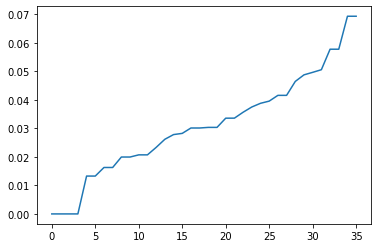

In [527]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(seattle_clustering)
distances, indices = nbrs.kneighbors(seattle_clustering)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

The optimal value for epsilon will be found at the point of maximum curvature. So we pick epsilon to equal 0.06

In [528]:
epsilon = 0.052
minimumSamples = 3
db = DBSCAN(eps=epsilon, min_samples=minimumSamples).fit(seattle_clustering)

In [529]:
labels = db.labels_
labels

array([ 1,  0,  0,  1,  1, -1, -1, -1, -1,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  1,  2,  1,  1,  1,
        2,  1], dtype=int64)

In [530]:
other.insert(0, 'Cluster Labels', db.labels_)
other

Cluster Labels    ZIP                    City Name       Sub Region  \
8                1  98028                      Kenmore            North   
9                0  98033                     Kirkland       East Urban   
10               0  98034                     Kirkland       East Urban   
11               1  98039                       Medina       East Urban   
12               1  98040                Mercer Island       East Urban   
16              -1  98055                       Renton      South Urban   
17              -1  98056                       Renton      South Urban   
18              -1  98058                       Renton      South Urban   
19              -1  98059                       Renton       East Urban   
22               0  98083                     Kirkland       East Urban   
25               1  98103                      Seattle          Seattle   
27               1  98105                      Seattle          Seattle   
28               1  98106                      Seattle          Seattle   
30               1  98108                      Seattle          Seattle   
35               1  98115                      Seattle          Seattle   
36               1  98116                      Seattle          Seattle   
38               1  98118                      Seattle          Seattle   
41               1  98122                      Seattle          Seattle   
42               1  98124                      Seattle          Seattle   
43               1  98125                      Seattle          Seattle   
44               1  98126                      Seattle          Seattle   
46               1  98133          Shoreline & Seattle  North & Seattle   
47               1  98134                      Seattle          Seattle   
48               1  98136                      Seattle          Seattle   
49               1  98138                      Seattle      South Urban   
50               1  98144                      Seattle          Seattle   
51               1  98145                      Seattle          Seattle   
52               1  98146                      Seattle  South & Seattle   
53               2  98148                       SeaTac      South Urban   
55               1  98155  Lake Forest Park, Shoreline            North   
56               2  98158                       SeaTac      South Urban   
57               1  98160                      Seattle            North   
60               1  98170                      Seattle      South Urban   
62               1  98177          Shoreline & Seattle  North & Seattle   
64               2  98188                       SeaTac      South Urban   
66               1  98195                      Seattle          Seattle   

     Neighborhood   Latitude   Longitude     Income  
8         Kenmore  47.754876 -122.247104  105007.00  
9        Kirkland  47.673156 -122.197628  125407.00  
10       Kirkland  47.715193 -122.210637   98683.00  
11         Medina  47.627636 -122.243170  192120.00  
12  Mercer Island  47.565229 -122.233149  142413.00  
16         Renton  47.451080 -122.196316   70647.00  
17         Renton  47.508872 -122.194960   85178.00  
18         Renton  47.435088 -122.116522   89608.00  
19         Renton  47.504128 -122.109663  102775.00  
22       Kirkland  47.681700 -122.207800       0.00  
25     Lake Union  47.670294 -122.348306   99048.00  
27      Northeast  47.660400 -122.280530   57417.00  
28       Delridge  47.547734 -122.352668   65781.00  
30       Duwamish  47.541083 -122.313312   58526.00  
35      Northeast  47.683612 -122.278022  108069.00  
36      Southwest  47.576292 -122.400639  107276.00  
38      Southeast  47.541963 -122.267649   72545.00  
41        Central  47.613527 -122.297335   74598.00  
42       Duwamish  47.606400 -122.330800       0.00  
43          North  47.715789 -122.293458   64429.00  
44       Delridge  47.551780 -122.372222   80142.00  
46      Northwest  47.739569 -122.344948

In [531]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(other['Latitude'], other['Longitude'], other['Neighborhood'], other['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Finding the Average Household Income by Cluster

So we have the clusters and their respective centroids as reference locations for potential restaurants. To decide which prospective location to pick we are going to look at the average household income among clusters.

In [241]:
group0 = other[other['Cluster Labels'] == 0]
group1 = other[other['Cluster Labels'] == 1]
group2 = other[other['Cluster Labels'] == 2]
group3 = other[other['Cluster Labels'] == 3]

A function to retrieve household incomes from zip codes in a dataframe. If there is one equal to zero it will be dropped from the dataframe and excluded from later calculations.

In [242]:
def getIncome(df):
    incomes = []
    for code in df['ZIP']:
        info = requests.get('https://api.zip-codes.com/ZipCodesAPI.svc/1.0/GetZipCodeDetails/{}?key=<AE7LR79I8JC8CNQRLGZF>'.format(code)).json()
        income = info['item']['IncomePerHousehold']
        incomes.append(income)
    df['Income'] = incomes
    df['Income'] = df['Income'].astype(float)
    df = df[df['Income'] != 0]
    return df

In [243]:
group0 = getIncome(group0)
group1 = getIncome(group1)
group2 = getIncome(group2)
group3 = getIncome(group3)

c:\program files\python\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
c:\program files\python\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [245]:
group0

Cluster Labels    ZIP                    City Name       Sub Region  \
25               0  98103                      Seattle          Seattle   
43               0  98125                      Seattle          Seattle   
46               0  98133          Shoreline & Seattle  North & Seattle   
55               0  98155  Lake Forest Park, Shoreline            North   
62               0  98177          Shoreline & Seattle  North & Seattle   

   Neighborhood   Latitude   Longitude    Income  
25   Lake Union  47.670294 -122.348306   99048.0  
43        North  47.715789 -122.293458   64429.0  
46    Northwest  47.739569 -122.344948   64001.0  
55    Shoreline  47.755304 -122.295911   86525.0  
62    Northwest  47.739168 -122.375316  109571.0

In [246]:
group1

Cluster Labels    ZIP      City Name       Sub Region   Neighborhood  \
12               1  98040  Mercer Island       East Urban  Mercer Island   
28               1  98106        Seattle          Seattle       Delridge   
30               1  98108        Seattle          Seattle       Duwamish   
36               1  98116        Seattle          Seattle      Southwest   
38               1  98118        Seattle          Seattle      Southeast   
41               1  98122        Seattle          Seattle        Central   
44               1  98126        Seattle          Seattle       Delridge   
47               1  98134        Seattle          Seattle       Duwamish   
48               1  98136        Seattle          Seattle      Southwest   
50               1  98144        Seattle          Seattle      Southeast   
52               1  98146        Seattle  South & Seattle      Southwest   

     Latitude   Longitude    Income  
12  47.565229 -122.233149  142413.0  
28  47.547734 -122.352668   65781.0  
30  47.541083 -122.313312   58526.0  
36  47.576292 -122.400639  107276.0  
38  47.541963 -122.267649   72545.0  
41  47.613527 -122.297335   74598.0  
44  47.551780 -122.372222   80142.0  
47  47.571247 -122.337752   74773.0  
48  47.536030 -122.393154  106240.0  
50  47.583944 -122.291488   74688.0  
52  47.500346 -122.363335   67556.0

In [247]:
group2

Cluster Labels    ZIP City Name   Sub Region Neighborhood   Latitude  \
16               2  98055    Renton  South Urban       Renton  47.451080   
17               2  98056    Renton  South Urban       Renton  47.508872   
18               2  98058    Renton  South Urban       Renton  47.435088   
19               2  98059    Renton   East Urban       Renton  47.504128   
53               2  98148    SeaTac  South Urban       SeaTac  47.446545   
64               2  98188    SeaTac  South Urban       SeaTac  47.448210   

     Longitude    Income  
16 -122.196316   70647.0  
17 -122.194960   85178.0  
18 -122.116522   89608.0  
19 -122.109663  102775.0  
53 -122.321828   56044.0  
64 -122.277851   57191.0

In [248]:
group3

Cluster Labels    ZIP City Name  Sub Region Neighborhood   Latitude  \
8                3  98028   Kenmore       North      Kenmore  47.754876   
9                3  98033  Kirkland  East Urban     Kirkland  47.673156   
10               3  98034  Kirkland  East Urban     Kirkland  47.715193   
11               3  98039    Medina  East Urban       Medina  47.627636   
27               3  98105   Seattle     Seattle    Northeast  47.660400   
35               3  98115   Seattle     Seattle    Northeast  47.683612   

     Longitude    Income  
8  -122.247104  105007.0  
9  -122.197628  125407.0  
10 -122.210637   98683.0  
11 -122.243170  192120.0  
27 -122.280530   57417.0  
35 -122.278022  108069.0

Let's create a resulting dataframe with cluster centroids locations and respective average incomes for a cluster

In [252]:
avg_income = [group0['Income'].mean(), group1['Income'].mean(), group2['Income'].mean(), group3['Income'].mean()]
data = {'Cluster': [0, 1, 2, 3], 'Latitude': kmeans.cluster_centers_[:, 0], 
        'Longitude': kmeans.cluster_centers_[:, 1], 'Average Income': avg_income}
final = pd.DataFrame(data, columns=['Cluster', 'Latitude', 'Longitude', 'Average Income'])
final

Cluster   Latitude   Longitude  Average Income
0        0  47.731671 -122.341140    84714.800000
1        1  47.570318 -122.329727    84048.909091
2        2  47.463492 -122.217595    76907.166667
3        3  47.681349 -122.245651   114450.500000

In [263]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(other['Latitude'], other['Longitude'], other['Neighborhood'], other['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

for k in range(kclusters):
    label = folium.Popup(str(final['Average Income'].array[k]) + ', Cluster Centroid ' + str(k), parse_html=True)
    folium.CircleMarker(
        [kmeans.cluster_centers_[k, 0], kmeans.cluster_centers_[k, 1]],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color='000000',
        fill_opacity=0.7).add_to(map_clusters)

       
map_clusters